In [54]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/feature_matrix_v1.csv")

df["ym"] = pd.to_datetime(df["ym"], format="%Y-%m")
df = df.sort_values("ym").reset_index(drop=True)

# rango consistente (IPI disponible)
df = df[df["ym"] >= "2017-01-01"].reset_index(drop=True)

df.head(), df.tail()


(          ym  emae_yoy   ipi_yoy   isac_yoy
 0 2017-01-01  1.399821 -1.130543  -1.810353
 1 2017-02-01 -1.544966 -7.957838  -5.648497
 2 2017-03-01  1.687721 -0.779551  10.618549
 3 2017-04-01 -0.851109 -3.791451  10.329531
 4 2017-05-01  2.981771  3.935284  12.095168,
             ym  emae_yoy   ipi_yoy   isac_yoy
 100 2025-05-01  5.086817  6.269615   9.369204
 101 2025-06-01  6.187663  9.579769  14.056358
 102 2025-07-01  3.027499 -0.814611   1.498121
 103 2025-08-01  2.454613 -4.270116   0.370704
 104 2025-09-01  5.009732 -0.454587   7.037448)

In [55]:
target = "emae_yoy"


In [56]:
lags = [0, 1, 2]  # contemporáneo + memoria corta

for var in ["ipi_yoy", "isac_yoy"]:
    for l in lags:
        name = f"{var}_l{l}"
        df[name] = df[var].shift(l)


In [57]:
features = [c for c in df.columns if c.startswith("ipi_yoy_l") or c.startswith("isac_yoy_l")]

df_now = df.dropna(subset=[target] + features).reset_index(drop=True)

df_now.shape, features


((103, 10),
 ['ipi_yoy_l0',
  'ipi_yoy_l1',
  'ipi_yoy_l2',
  'isac_yoy_l0',
  'isac_yoy_l1',
  'isac_yoy_l2'])

In [58]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def walk_forward_nowcast(df, features, target, start_train=24):
    preds = []

    for t in range(start_train, len(df)):
        train = df.iloc[:t]
        test  = df.iloc[t:t+1]

        X_train, y_train = train[features], train[target]
        X_test,  y_test  = test[features],  test[target]

        model = Pipeline([
            ("scaler", StandardScaler()),
            ("lasso", LassoCV(cv=5, random_state=42))
        ])
        model.fit(X_train, y_train)
        yhat = float(model.predict(X_test))

        preds.append({
            "ym": test["ym"].values[0],
            "y_true": float(y_test.values[0]),
            "yhat": yhat
        })

    return pd.DataFrame(preds)


In [59]:
wf = walk_forward_nowcast(
    df_now,
    features,
    target="emae_yoy",
    start_train=24
)

wf.tail()


,ym,y_true,yhat
74,2025-05-01,5.086817,4.093683
75,2025-06-01,6.187663,5.954960
76,2025-07-01,3.027499,0.777930
77,2025-08-01,2.454613,-0.710592
78,2025-09-01,5.009732,0.477352


In [60]:
from sklearn.metrics import mean_absolute_error

wf["yhat_naive"] = wf["y_true"].shift(1)
wf = wf.dropna()

mean_absolute_error(wf["y_true"], wf["yhat"]), \
mean_absolute_error(wf["y_true"], wf["yhat_naive"])


(4.332927578712526, 3.1135690628819037)

In [61]:
wf["acc_true"] = wf["y_true"].diff()
wf["acc_hat"]  = wf["yhat"].diff()
(np.sign(wf["acc_true"]) == np.sign(wf["acc_hat"])).mean()


0.8589743589743589

<AxesSubplot:xlabel='ym'>

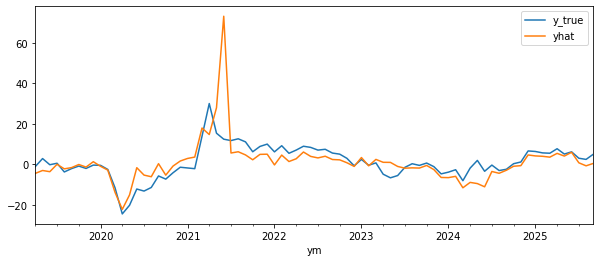

In [62]:
wf.set_index("ym")[["y_true", "yhat"]].plot(figsize=(10,4))


In [63]:
wf["signal_raw"] = (
    0.6 * wf["acc_hat"] +
    0.4 * wf["yhat"].rolling(3).mean()
)


In [64]:
def minmax(s):
    return (s - s.min()) / (s.max() - s.min())

wf["signal_score"] = minmax(wf["signal_raw"]) * 100


In [65]:
wf = wf.sort_values("ym").reset_index(drop=True)

wf["acc_hat"]  = wf["yhat"].diff()
wf["acc_true"] = wf["y_true"].diff()


In [66]:
(np.sign(wf["acc_hat"]) == np.sign(wf["acc_true"])).mean()


0.8589743589743589

In [67]:
wf["acc_smooth"] = wf["acc_hat"].rolling(3).mean()


In [68]:
wf["signal_raw"] = wf["acc_smooth"]


In [69]:
low, high = wf["signal_raw"].quantile([0.05, 0.95])

wf["signal_clip"] = wf["signal_raw"].clip(lower=low, upper=high)
wf["signal_score"] = (
    (wf["signal_clip"] - low) / (high - low) * 100
)


In [70]:
def regime(score):
    if score < 30:
        return "Contracción"
    elif score < 60:
        return "Transición"
    else:
        return "Expansión"

wf["regime"] = wf["signal_score"].apply(regime)


In [71]:
app_df = wf[[
    "ym",
    "signal_score",
    "regime",
    "yhat"
]].copy()

app_df.tail(12)


,ym,signal_score,regime,yhat
66,2024-10-01,59.171190,Transición,-0.926690
67,2024-11-01,63.639755,Expansión,-0.626877
68,2024-12-01,77.910900,Expansión,4.643521
69,2025-01-01,68.678720,Expansión,4.170774
70,2025-02-01,66.848896,Expansión,3.986040
71,2025-03-01,45.340805,Transición,3.560989
72,2025-04-01,54.162178,Transición,5.424185
73,2025-05-01,49.835338,Transición,4.093683
74,2025-06-01,58.469345,Transición,5.954960
75,2025-07-01,31.882886,Transición,0.777930


In [72]:
app_df.to_csv("../data/emae_signal_app.csv", index=False)


In [73]:
print(df["ym"].min(), df["ym"].max())
print(df.tail())


2017-01-01 00:00:00 2025-09-01 00:00:00
            ym  emae_yoy   ipi_yoy   isac_yoy  ipi_yoy_l0  ipi_yoy_l1  \
100 2025-05-01  5.086817  6.269615   9.369204    6.269615    9.063286   
101 2025-06-01  6.187663  9.579769  14.056358    9.579769    6.269615   
102 2025-07-01  3.027499 -0.814611   1.498121   -0.814611    9.579769   
103 2025-08-01  2.454613 -4.270116   0.370704   -4.270116   -0.814611   
104 2025-09-01  5.009732 -0.454587   7.037448   -0.454587   -4.270116   

     ipi_yoy_l2  isac_yoy_l0  isac_yoy_l1  isac_yoy_l2  
100    5.166505     9.369204    25.940057    15.750312  
101    9.063286    14.056358     9.369204    25.940057  
102    6.269615     1.498121    14.056358     9.369204  
103    9.579769     0.370704     1.498121    14.056358  
104   -0.814611     7.037448     0.370704     1.498121  
